In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import pickle

In [2]:
import networkx as nx
import EoN

### datasets

In [3]:
rental_point = pd.read_csv('./data/public_bike_rental_point.csv', encoding='cp949')
rental_data = pd.read_csv('./data/public_bike_rental_log.csv', encoding='cp949')

In [4]:
rental_point.head()

,대여소_구,대여소ID,대여소명,대여소주소,위도,경도,기준시작일자,거치대수
0,마포구,101,101. (구)합정동 주민센터,서울특별시 마포구 동교로8길 58,37.549561,126.905754,2015-09-06 23:40,5
1,마포구,102,102. 망원역 1번출구 앞,서울특별시 마포구 월드컵로 72,37.555649,126.910629,2015-09-06 23:42,20
2,마포구,103,103. 망원역 2번출구 앞,서울특별시 마포구 월드컵로 79,37.554951,126.910835,2015-09-06 23:43,14
3,마포구,104,104. 합정역 1번출구 앞,서울특별시 마포구 양화로 59,37.550629,126.914986,2015-09-06 23:44,13
4,마포구,105,105. 합정역 5번출구 앞,서울특별시 마포구 양화로 48,37.550007,126.914825,2015-09-06 23:45,5


In [5]:
rental_point.shape

(1540, 8)

In [6]:
rental_data.head()

,자전거번호,대여일시,대여 대여소번호,대여 대여소명,대여거치대,반납일시,반납대여소번호,반납대여소명,반납거치대,이용시간,이용거리
0,SPB-33273,2020-06-01 00:03:05,1050,둔촌역 3번 출입구,0,2020-06-01 00:05:59,1078,둔촌사거리,0,3,0.0
1,SPB-30703,2020-06-01 00:00:46,1132,등촌역 7번출구,0,2020-06-01 00:06:53,1169,염창역 1번 출구,0,6,0.0
2,SPB-31969,2020-06-01 00:02:43,1306,한성대입구역2번출구,0,2020-06-01 00:06:59,388,동성중학교 앞,0,4,0.0
3,SPB-19763,2020-06-01 00:00:16,956,응암시장교차로,8,2020-06-01 00:08:25,939,은평구청 교차로,6,7,1340.0
4,SPB-32949,2020-06-01 00:04:20,709,신정3동 현장민원실 앞,0,2020-06-01 00:08:53,712,강월초교입구 사거리,0,5,0.0


In [7]:
## Edge에 있는 모든 Node가 모두 Node 파일에 있도록 처리
index = [] # edge에 있는 node가 모두 node 파일에 있는 경우를 담기 위한 리스트
point = rental_point['대여소ID'].values

for i in range(len(rental_data)):
    if (rental_data['대여 대여소번호'][i] in point) and (rental_data['반납대여소번호'][i] in point):
        index.append(i)
        
rental_data = rental_data.loc[index,:]
rental_data.index = range(len(rental_data))

# Self Loop 제거
rental_data = rental_data.drop(rental_data[rental_data['대여 대여소번호']==rental_data['반납대여소번호']].index, axis=0)
rental_data.index = range(len(rental_data))
rental_data

,자전거번호,대여일시,대여 대여소번호,대여 대여소명,대여거치대,반납일시,반납대여소번호,반납대여소명,반납거치대,이용시간,이용거리
0,SPB-30703,2020-06-01 00:00:46,1132,등촌역 7번출구,0,2020-06-01 00:06:53,1169,염창역 1번 출구,0,6,0.00
1,SPB-31969,2020-06-01 00:02:43,1306,한성대입구역2번출구,0,2020-06-01 00:06:59,388,동성중학교 앞,0,4,0.00
2,SPB-19763,2020-06-01 00:00:16,956,응암시장교차로,8,2020-06-01 00:08:25,939,은평구청 교차로,6,7,1340.00
3,SPB-32949,2020-06-01 00:04:20,709,신정3동 현장민원실 앞,0,2020-06-01 00:08:53,712,강월초교입구 사거리,0,5,0.00
4,SPB-33628,2020-06-01 00:00:34,1153,"발산역 1번, 9번 인근 대여소",0,2020-06-01 00:09:35,1125,명덕고교입구(영종빌딩),0,9,0.00
...,...,...,...,...,...,...,...,...,...,...,...
1368844,SPB-32165,2020-06-30 22:06:58,2119,중앙동 동진빌딩,0,2020-07-01 01:10:36,2173,당곡사거리,0,184,11136.53
1368845,SPB-32376,2020-06-30 23:28:03,1966,한마을아파트 정문상가,0,2020-07-01 01:11:57,112,극동방송국 앞,0,104,12893.96
1368846,SPB-31686,2020-06-30 23:25:40,103,망원역 2번출구 앞,0,2020-07-01 01:44:24,151,망원1동주민센터,0,139,2301.87
1368847,SPB-14454,2020-06-30 18:55:01,1235,잠실트리지움310동 옆,3,2020-07-01 02:46:48,1221,삼전사거리 포스코더샵,4,471,870.00


In [8]:
# Rental Graph 불러오기
with open('rental_g.pickle', 'rb') as fr:
    rental_g = pickle.load(fr)

## Statistics

### Weighted Degree

**weighted degree(weight)**

In [9]:
source = rental_data.groupby('대여 대여소번호')['이용시간'].count().reset_index()
target = rental_data.groupby('반납대여소번호')['이용시간'].count().reset_index()
source.rename(columns={'이용시간':'out'}, inplace=True)
target.rename(columns={'이용시간':'in'}, inplace=True)
rental_deg = pd.merge(rental_point, source, how='left', left_on='대여소ID', right_on='대여 대여소번호')
rental_deg = pd.merge(rental_deg, target, how='left', left_on='대여소ID', right_on='반납대여소번호')
rental_deg = rental_deg.fillna(0)
rental_deg['total'] = rental_deg['out'] + rental_deg['in']

In [10]:
rental_deg_sorted = rental_deg.loc[np.argsort(-rental_deg.total)].reset_index(drop=True)
deg_top10 = rental_deg_sorted.loc[0:9,['대여소ID']]
deg_top10 = [v for v in deg_top10['대여소ID']]

#### weighted degree(time)

In [11]:
source_t = rental_data.groupby('대여 대여소번호')['이용시간'].sum().reset_index()
target_t = rental_data.groupby('반납대여소번호')['이용시간'].sum().reset_index()
source_t.rename(columns={'이용시간':'out'}, inplace=True)
target_t.rename(columns={'이용시간':'in'}, inplace=True)
rental_t = pd.merge(rental_point, source_t, how='left', left_on='대여소ID', right_on='대여 대여소번호')
rental_t = pd.merge(rental_t, target_t, how='left', left_on='대여소ID', right_on='반납대여소번호')
rental_t = rental_t.fillna(0)
rental_t['total'] = rental_t['out'] + rental_t['in']

In [12]:
rental_t_sorted = rental_t.loc[np.argsort(-rental_t.total)].reset_index(drop=True)
t_top10 = rental_t_sorted.loc[0:9,['대여소ID']]
t_top10 = [v for v in t_top10['대여소ID']]

#### Weighted Degree(distance)

In [13]:
source_d = rental_data.groupby('대여 대여소번호')['이용거리'].sum().reset_index()
target_d = rental_data.groupby('반납대여소번호')['이용거리'].sum().reset_index()
source_d.rename(columns={'이용거리':'out'}, inplace=True)
target_d.rename(columns={'이용거리':'in'}, inplace=True)
rental_d = pd.merge(rental_point, source_d, how='left', left_on='대여소ID', right_on='대여 대여소번호')
rental_d = pd.merge(rental_d, target_d, how='left', left_on='대여소ID', right_on='반납대여소번호')
rental_d = rental_d.fillna(0)
rental_d['total'] = rental_d['out'] + rental_d['in']

In [14]:
rental_d_sorted = rental_d.loc[np.argsort(-rental_d.total)].reset_index(drop=True)
d_top10 = rental_d_sorted.loc[0:9,['대여소ID']]
d_top10 = [v for v in d_top10['대여소ID']]

### Betweenness Centrality

In [15]:
bet = nx.betweenness_centrality(rental_g)
bet_sort = sorted(bet, key=bet.get, reverse=True)

In [16]:
bet_top10 = rental_point[rental_point['대여소ID'].isin(bet_sort[0:9])]['대여소ID'].tolist()

### PageRank

In [17]:
pgrank = nx.pagerank(rental_g)
pgrank_sort = sorted(pgrank, key=pgrank.get, reverse=True)

In [18]:
pg_top10 = rental_point[rental_point['대여소ID'].isin(pgrank_sort[0:9])]['대여소ID'].tolist()

## Epidemics on Network

In [70]:
## EoN Model Setup

tmax = 100
iterations = 30
tau = 0.0025 # transmission rate per edge
gamma = 0.8 # recovery rate per node
rho = 0.0065 # 초기 확진자 비율

In [71]:
# for calculating rho
10/1540

0.006493506493506494

### SIS Model

#### Weight 기준

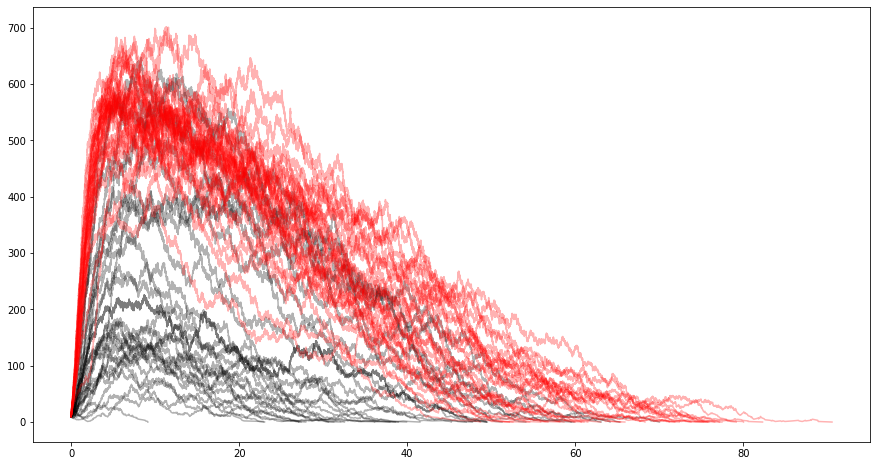

In [72]:
plt.figure(figsize=(15,8))

for counter in range(iterations):
    t, S, I = EoN.fast_SIS(rental_g, tau, gamma, rho=rho, tmax=tmax, transmission_weight='weight')
    if counter == 0:
        plt.plot(t, I, color='k', alpha=0.3, label='Simulation')
    plt.plot(t, I, color='k', alpha=0.3)
    
for counter in range(iterations):
    t, S, I = EoN.fast_SIS(rental_g, tau, gamma, tmax=tmax, transmission_weight='weight', initial_infecteds=deg_top10)
    plt.plot(t, I, color='r', alpha=0.3)

#### Time

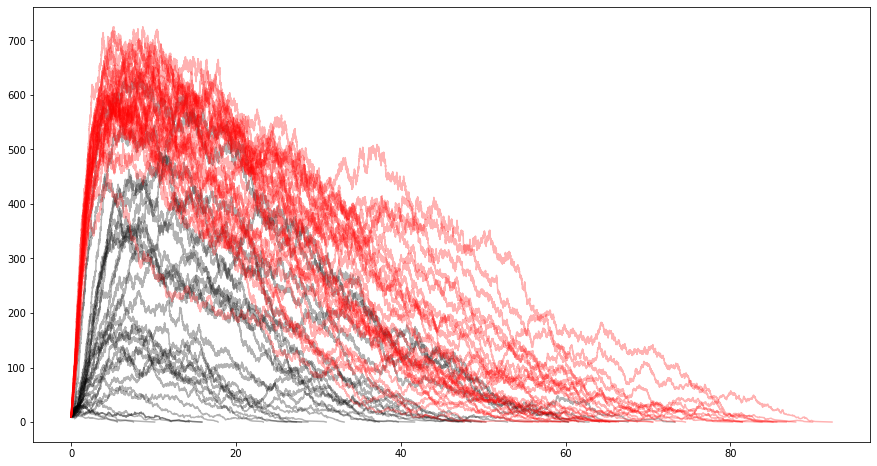

In [73]:
plt.figure(figsize=(15,8))

for counter in range(iterations):
    t, S, I = EoN.fast_SIS(rental_g, tau, gamma, rho=rho, tmax=tmax, transmission_weight='weight')
    if counter == 0:
        plt.plot(t, I, color='k', alpha=0.3, label='Simulation')
    plt.plot(t, I, color='k', alpha=0.3)
    
for counter in range(iterations):
    t, S, I = EoN.fast_SIS(rental_g, tau, gamma, tmax=tmax, transmission_weight='weight', initial_infecteds=t_top10)
    plt.plot(t, I, color='r', alpha=0.3)

#### Distance

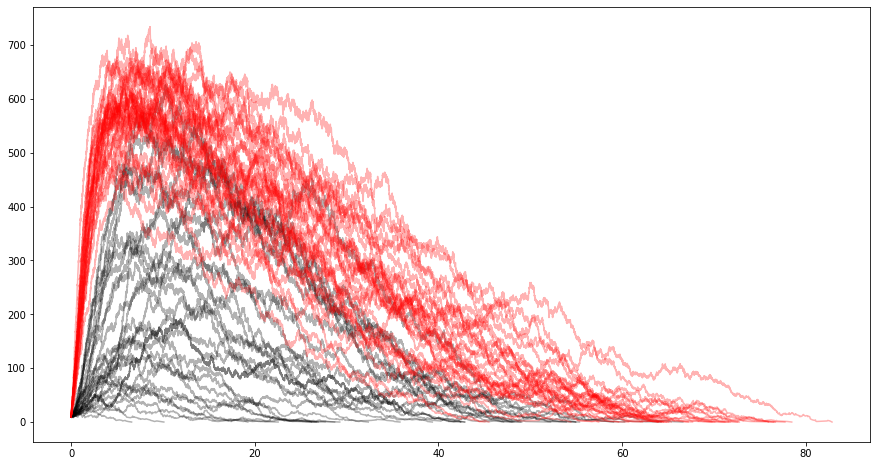

In [74]:
plt.figure(figsize=(15,8))

for counter in range(iterations):
    t, S, I = EoN.fast_SIS(rental_g, tau, gamma, rho=rho, tmax=tmax, transmission_weight='weight')
    if counter == 0:
        plt.plot(t, I, color='k', alpha=0.3, label='Simulation')
    plt.plot(t, I, color='k', alpha=0.3)
    
for counter in range(iterations):
    t, S, I = EoN.fast_SIS(rental_g, tau, gamma, tmax=tmax, transmission_weight='weight', initial_infecteds=d_top10)
    plt.plot(t, I, color='r', alpha=0.3)

#### Betweenness Centrality

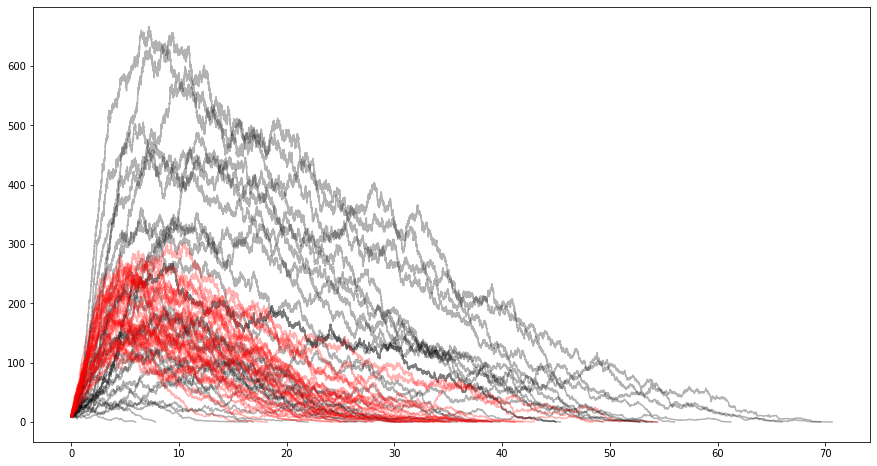

In [75]:
plt.figure(figsize=(15,8))

for counter in range(iterations):
    t, S, I = EoN.fast_SIS(rental_g, tau, gamma, rho=rho, tmax=tmax, transmission_weight='weight')
    if counter == 0:
        plt.plot(t, I, color='k', alpha=0.3, label='Simulation')
    plt.plot(t, I, color='k', alpha=0.3)
    
for counter in range(iterations):
    t, S, I = EoN.fast_SIS(rental_g, tau, gamma, tmax=tmax, transmission_weight='weight', initial_infecteds=bet_top10)
    plt.plot(t, I, color='r', alpha=0.3)

#### PageRank

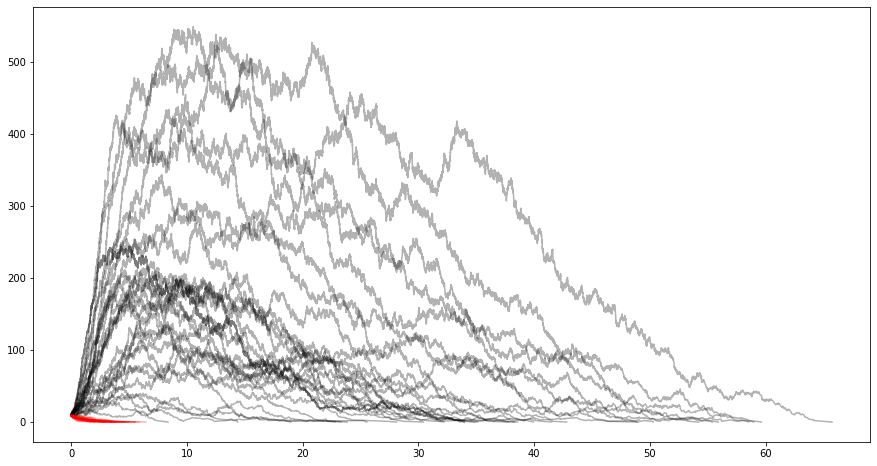

In [76]:
plt.figure(figsize=(15,8))

for counter in range(iterations):
    t, S, I = EoN.fast_SIS(rental_g, tau, gamma, rho=rho, tmax=tmax, transmission_weight='weight')
    if counter == 0:
        plt.plot(t, I, color='k', alpha=0.3, label='Simulation')
    plt.plot(t, I, color='k', alpha=0.3)
    
for counter in range(iterations):
    t, S, I = EoN.fast_SIS(rental_g, tau, gamma, tmax=tmax, transmission_weight='weight', initial_infecteds=pg_top10)
    plt.plot(t, I, color='r', alpha=0.3)

## 시각화

In [63]:
# Graph Layout
layout = {}

for i in rental_point.index:
    ID = rental_point.at[i, '대여소ID'] # key
    lat = rental_point.at[i,'위도']
    long = rental_point.at[i, '경도']
    layout[ID] = np.array([long, lat]) # 순서 주의!! 경도가 x축, 위도가 y축임

In [64]:
from matplotlib import animation, rc
from IPython.display import HTML

In [65]:
def _display_time_series_(self, fig, t, ts_plots, ts_list, timelabel):
        if ts_list is None:
            ts_list = self._time_series_list_
        elif self._simulation_time_series_ not in ts_list:
            ts_list.append(self._simulation_time_series_)
        
        ts_axes = []
        time_markers = []
        ts_plot_count = len(ts_plots)        
        for cnt, ts_plot in enumerate(ts_plots[:-1]):
            ax = fig.add_subplot(ts_plot_count, 2, 2*(cnt+1))
            ax.set_xticks([])
            
            for ts in reversed(ts_list):
                ts._plot_(ax, ts_plot)  
                              
            ax.legend()
            
            if self._tex_:
                ax.set_title(", ".join(['${}$'.format(status) for status in ts_plot]))
            else:
                ax.set_title(", ".join(ts_plot))
                
            tm = ax.axvline(x=t, linestyle='--', color='k')
            ts_axes.append(ax)
            time_markers.append(tm)
            
        ax = fig.add_subplot(ts_plot_count, 2, 2*ts_plot_count)
        ax.set_xlabel(timelabel)
        ts_plot = ts_plots[-1]
        
        for ts in reversed(ts_list):
            ts._plot_(ax, ts_plot)                
        ax.legend()
        
        if self._tex_:
            ax.set_title(", ".join(['${}$'.format(status) for status in ts_plot]))
        else:
            ax.set_title(", ".join(ts_plot))

        tm = ax.axvline(x=t, linestyle='--', color='k')
        ts_axes.append(ax)
        time_markers.append(tm)
        return ts_axes, time_markers

In [66]:
from matplotlib.animation import FuncAnimation
import random

def animate(self, frame_times=None, ts_plots = None, 
                ts_list = None, nodelist=None, status_order=False, timelabel=r'$t$',  
                pos = None, statuses_to_plot = None, **nx_kwargs):
        if frame_times is None:
            frame_times = np.linspace(0,self._t_[-1], 101)
        if statuses_to_plot is None:
            statuses_to_plot = self._possible_statuses_
        if ts_plots is None:
            ts_plots = statuses_to_plot
        if ts_plots:
            fig = plt.figure(figsize=(20,12))
            graph_ax = fig.add_subplot(121)
        else:
            fig = plt.figure()
            graph_ax = fig.add_subplot(111)

        
        initial_status = self.get_statuses(self.G, frame_times[0])
    
        if pos is None:
            if self.pos is None:
                pos = nx.spring_layout(self.G)
            else:
                pos = self.pos
    
        if nodelist is None:
            nodelist = list(self.G.nodes())
            random.shuffle(nodelist)
            
        if status_order is False:
            status_order = []
            
        #First we draw all of the nodes with their original status, and without
        #putting particular status on top.  All nodes are in place, and their color
        #can be updated at a later time.
        #
        #Then we select the nodes whose status puts them on top initially
        #
        #For each status that goes on top, we draw it in a way that we'll be
        #able to redraw that status at a later time.
        drawn_nodes = self._display_graph_(pos, initial_status, nodelist, False, statuses_to_plot, graph_ax, **nx_kwargs)
        elevated = {status: [node for node in self.G if initial_status[node] == status] for status in status_order}

        drawn_elevated = {}
        for status in reversed(status_order):
            drawn_elevated[status]=[self._draw_specific_status_(pos, elevated[status], status, graph_ax, **nx_kwargs)] #making each a list so that I can change the entry in the list while still passing the same object
        #WARNING I'm defining a dict and while that definition is happening
        #it's drawing things
        
        
        
        
        if ts_plots:
            ts_axes, time_markers = _display_time_series_(self, fig, frame_times[0], ts_plots, ts_list, timelabel)
        else:
            ts_axes, time_markers = [], []
        plt.tight_layout()
        
        fargs = (pos, nodelist, drawn_nodes, drawn_elevated, status_order, graph_ax, ts_axes, time_markers, nx_kwargs)

        ani = FuncAnimation(fig, self._update_ani_, frames = frame_times, fargs = fargs, repeat=False)

        return ani

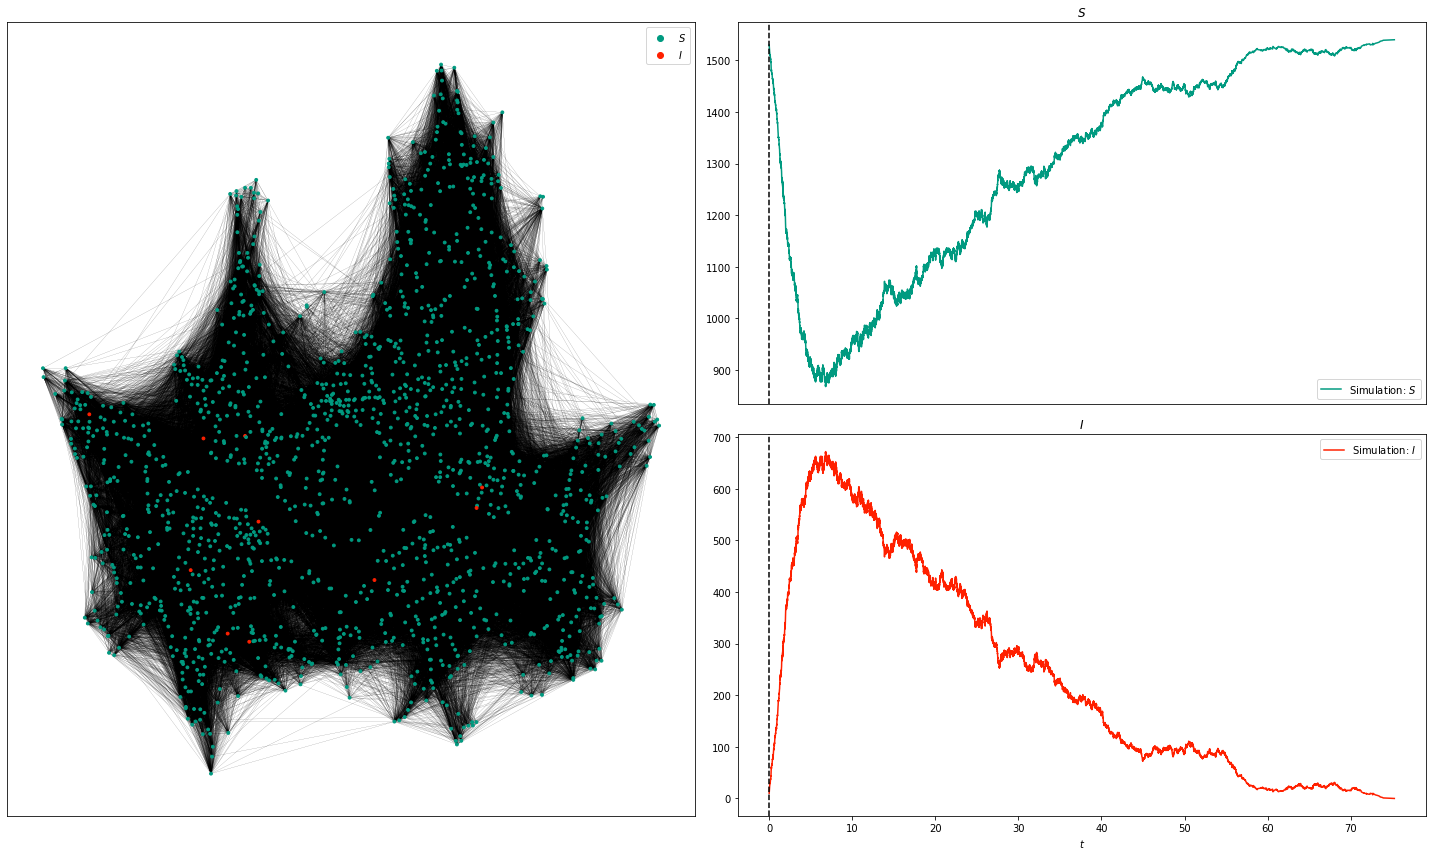

In [77]:
sim_kwargs = {'pos': layout}

sim = EoN.fast_SIS(rental_g, tau, gamma, initial_infecteds=deg_top10, tmax=80, transmission_weight='weight', 
                   return_full_data=True, sim_kwargs = sim_kwargs)

# ts_plot : 애니메이션에 함꼐 넣을 plot ( I : 전염plot, S : recover plot)
ani = animate(self=sim,node_size = 8, ts_plot=['I'], width = 0.1,withlabels=False,arrows=False)

HTML(ani.to_html5_video())

### Random

In [ ]:
sim_kwargs = {'pos': layout}

sim = EoN.fast_SIS(rental_g, tau, gamma, rho=rho, tmax=tmax, transmission_weight='weight', return_full_data=True, sim_kwargs = sim_kwargs)

ani = animate(self=sim,node_size = 8, ts_plot=['I'], width = 0.1,withlabels=False,arrows=False)

rc('animation', html='html5')
ani

In [ ]:
sim_kwargs = {'pos': layout}

sim = EoN.fast_SIS(rental_g, tau, gamma, rho=rho, tmax=tmax, transmission_weight='weight', return_full_data=True, sim_kwargs = sim_kwargs)

ani = animate(self=sim,node_size = 8, ts_plot=['I'], width = 0.1,withlabels=False,arrows=False)

rc('animation', html='html5')
ani

In [ ]:
sim_kwargs = {'pos': layout}

sim = EoN.fast_SIS(rental_g, tau, gamma, rho=rho, tmax=tmax, transmission_weight='weight', return_full_data=True, sim_kwargs = sim_kwargs)

ani = animate(self=sim,node_size = 8, ts_plot=['I'], width = 0.1,withlabels=False,arrows=False)

rc('animation', html='html5')
ani

In [ ]:
sim_kwargs = {'pos': layout}

sim = EoN.fast_SIS(rental_g, tau, gamma, rho=rho, tmax=tmax, transmission_weight='weight', return_full_data=True, sim_kwargs = sim_kwargs)

ani = animate(self=sim,node_size = 8, ts_plot=['I'], width = 0.1,withlabels=False,arrows=False)

rc('animation', html='html5')
ani

In [ ]:
sim_kwargs = {'pos': layout}

sim = EoN.fast_SIS(rental_g, tau, gamma, rho=rho, tmax=tmax, transmission_weight='weight', return_full_data=True, sim_kwargs = sim_kwargs)

ani = animate(self=sim,node_size = 8, ts_plot=['I'], width = 0.1,withlabels=False,arrows=False)

rc('animation', html='html5')
ani